# Importing libraries | Импорт библиотек:

In [4]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, numpy as np
sns.set_theme(style = "ticks", palette = "mako", font_scale = 0.75, rc = {'figure.figsize':(15, 10)})

from scipy.stats import iqr, trim_mean
from operator import attrgetter

from google.colab import drive
drive.mount("/content/drive")
data_path = "/content/drive/MyDrive/Recommendation system/Data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Acquiring and processing the data | Получение и обработка данных:

In [5]:
df_lots = pd.read_csv(data_path + "data.csv", delimiter = ";", dtype = {"okpd2_code2": str})
df_participants = pd.read_csv(data_path + "participants.csv", delimiter = ";")

<ipython-input-5-7a2822675c2d>:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lots = pd.read_csv(data_path + "data.csv", delimiter = ";", dtype = {"okpd2_code2": str})


## Deleting ambiguous values | Удаление неоднозначных значений:

### Deleting ambiguous OKPD2 codes | Удаление неоднозначных кодов ОКПД2:

In [6]:
ambiguous_okpd2_codes = ["2727", "2746", "2747", "2723", "2736", "2735", "2733", "2726", "2725", "2790", "2724", "2728", "2763", "2771"]

df_lots = df_lots[~df_lots["okpd2_code2"].isin(ambiguous_okpd2_codes)]

### Cutting off 2023 year | Обрезание 2023 года:

In [7]:
df_lots = df_lots[df_lots["min_publish_date"] < "2023-01-01"]

## Filling missing values | Заполнение пустых значений:

In [8]:
df_lots.fillna(value = "Null", inplace = True)

## Merging the data | Объединение данных:



In [9]:
df_merged = df_lots.merge(df_participants, how = "inner", on = "pn_lot_md5")

## Extracting years from dates | Вычленение года из дат:

In [10]:
df_lots["min_publish_date"] = pd.to_datetime(df_lots["min_publish_date"])
df_lots["year"] = df_lots["min_publish_date"].dt.year
df_lots["month"] = df_lots["min_publish_date"].dt.month

In [11]:
df_merged["min_publish_date"] = pd.to_datetime(df_merged["min_publish_date"])
df_merged["year"] = df_merged["min_publish_date"].dt.year
df_merged["month"] = df_merged["min_publish_date"].dt.month

# Exploratory data analysis | Анализ данных:

## Federal law | ФЗ:

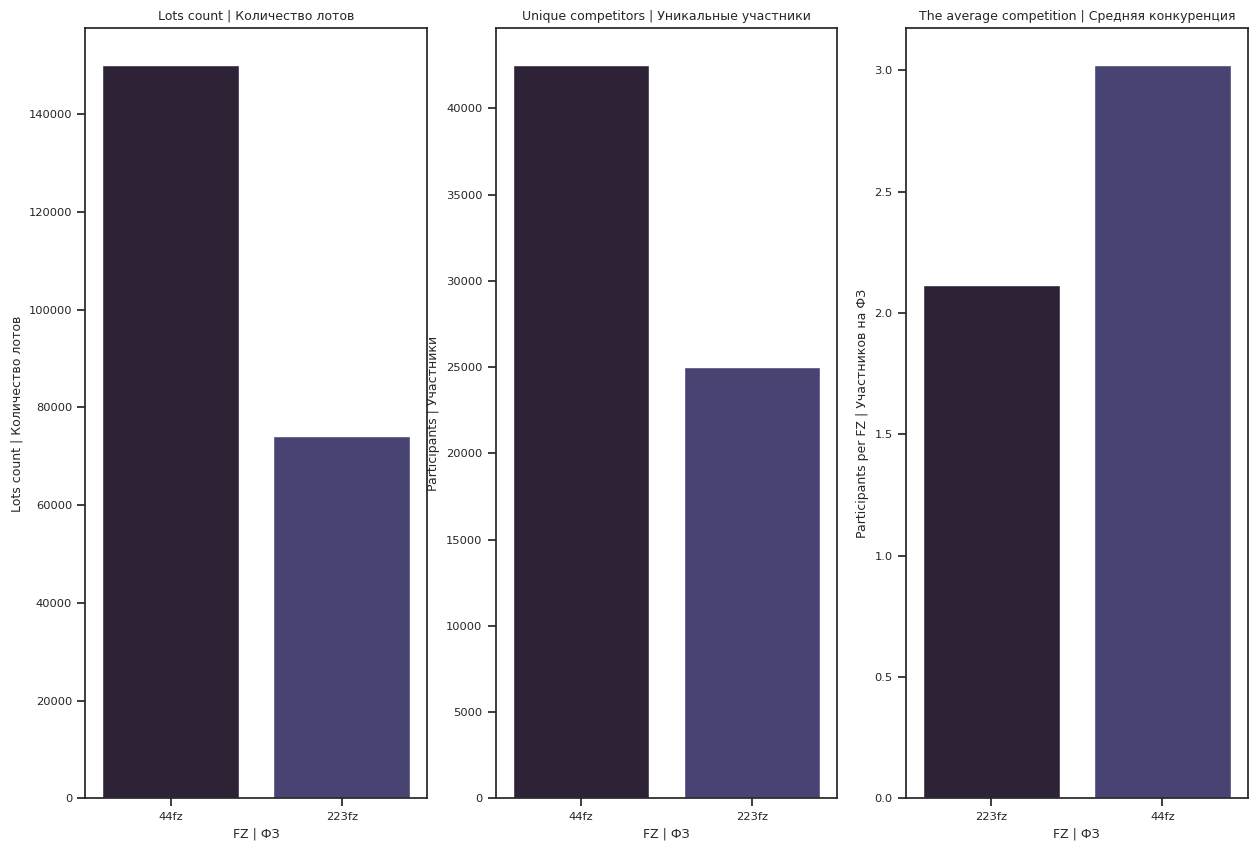

In [12]:
fig_fz, axs_fz = plt.subplots(ncols = 3)

# Lots count | Количество лотов:
fz1 = sns.countplot(data = df_lots, x = "fz", ax = axs_fz[0])
fz1.set(title = "Lots count | Количество лотов",
        xlabel = "FZ | ФЗ",
        ylabel = "Lots count | Количество лотов")

# Unique competitors | Уникальные участники:
unique_competitors_fz = df_merged.groupby("fz")["participant_inn_kpp"].nunique().sort_values(ascending = False)

fz2 = sns.barplot(x = unique_competitors_fz.index, y = unique_competitors_fz, ax = axs_fz[1])
fz2.set(title = "Unique competitors | Уникальные участники",
        xlabel = "FZ | ФЗ",
        ylabel = "Participants | Участники")

# The average competition | Средняя конкуренция:
count_participants_fz = df_merged.groupby("fz")["participant_inn_kpp"].count()
count_lots_fz = df_lots.groupby("fz")["pn_lot_md5"].count()
average_competition_fz = count_participants_fz / count_lots_fz

fz3 = sns.barplot(x = average_competition_fz[:5].index, y = average_competition_fz[:5], ax = axs_fz[2])
fz3.set(title = "The average competition | Средняя конкуренция",
        xlabel = "FZ | ФЗ",
        ylabel = "Participants per FZ | Участников на ФЗ")

fig_fz.show()

## OKPD2 codes | Коды ОКПД2:

okpd2_code2
27.1    680564.260
27.2     99990.900
27.3    250800.000
27.4    132833.900
27.5     95710.835
27.9    490000.000
Name: lot_price, dtype: float64

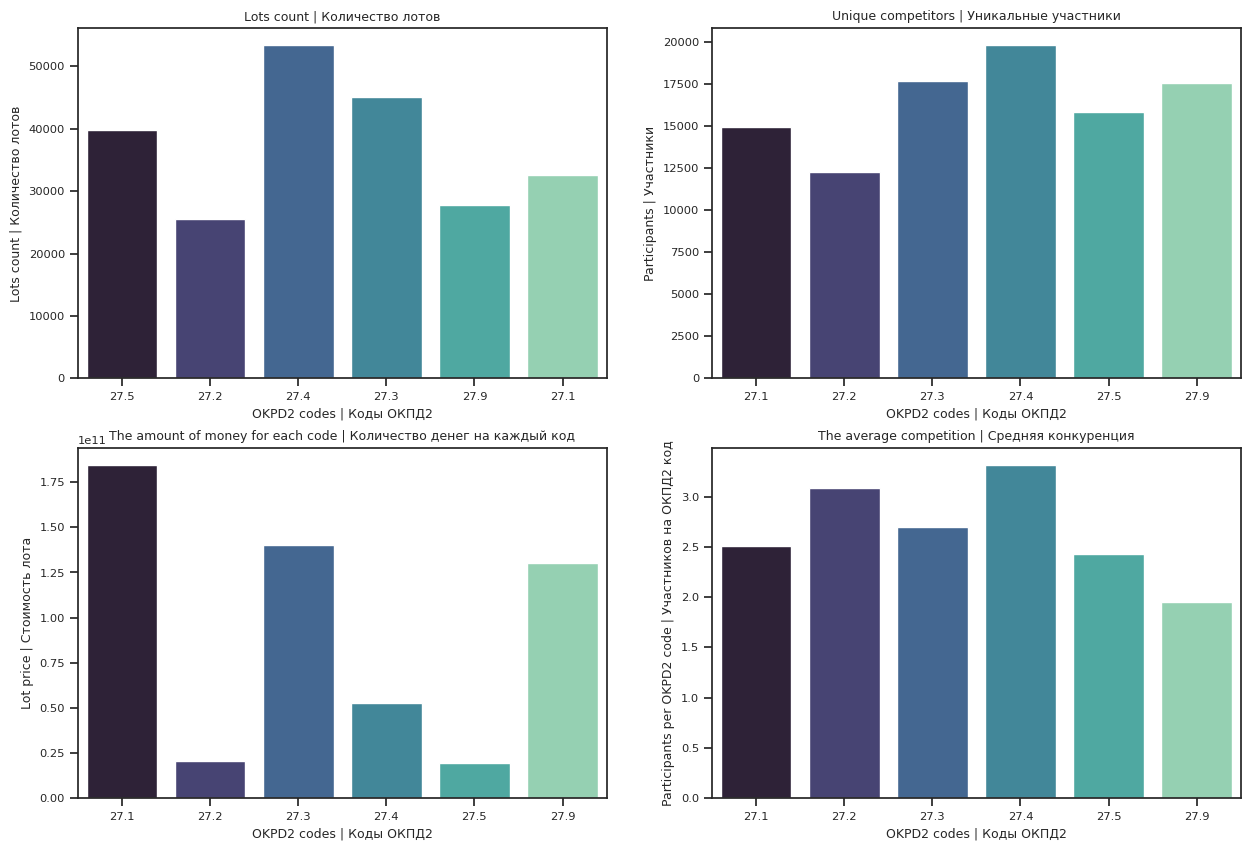

In [13]:
fig_okpd2, axs_okpd2 = plt.subplots(2, 2)

# Lots count | Количество лотов:
okpd21 = sns.countplot(data = df_lots, x = "okpd2_code2", ax = axs_okpd2[0, 0])
okpd21.set(title = "Lots count | Количество лотов",
           xlabel = "OKPD2 codes | Коды ОКПД2",
           ylabel = "Lots count | Количество лотов")

# Unique competitors | Уникальные участники:
unique_competitors_okpd2_codes = df_merged.groupby("okpd2_code2")["participant_inn_kpp"].nunique()

okpd22 = sns.barplot(x = unique_competitors_okpd2_codes.index, y = unique_competitors_okpd2_codes, ax = axs_okpd2[0, 1])
okpd22.set(title = "Unique competitors | Уникальные участники",
           xlabel = "OKPD2 codes | Коды ОКПД2",
           ylabel = "Participants | Участники")

# The amount of money per code | Количество денег на код:
lot_price_okpd2_codes_sum = df_lots.groupby("okpd2_code2")["lot_price"].agg("sum")

okpd23 = sns.barplot(x = lot_price_okpd2_codes_sum.index, y = lot_price_okpd2_codes_sum, ax = axs_okpd2[1, 0])
okpd23.set(title = "The amount of money for each code | Количество денег на каждый код",
           xlabel = "OKPD2 codes | Коды ОКПД2",
           ylabel = "Lot price | Стоимость лота")

# The average competition | Средняя конкуренция:
count_participants_okpd2 = df_merged.groupby("okpd2_code2")["participant_inn_kpp"].count()
count_lots_okpd2 = df_lots.groupby("okpd2_code2")["pn_lot_md5"].count()
average_competition_okpd2 = count_participants_okpd2 / count_lots_okpd2

okpd24 = sns.barplot(x = average_competition_okpd2.index, y = average_competition_okpd2, ax = axs_okpd2[1, 1])
okpd24.set(title = "The average competition | Средняя конкуренция",
           xlabel = "OKPD2 codes | Коды ОКПД2",
           ylabel = "Participants per OKPD2 code | Участников на ОКПД2 код")

fig_okpd2.show()

df_lots.groupby("okpd2_code2")["lot_price"].agg("median")

## Region codes | Коды регионов:

region_code
20    1209260.000
87     584184.760
77     499963.675
49     444851.665
88     440468.420
Name: lot_price, dtype: float64

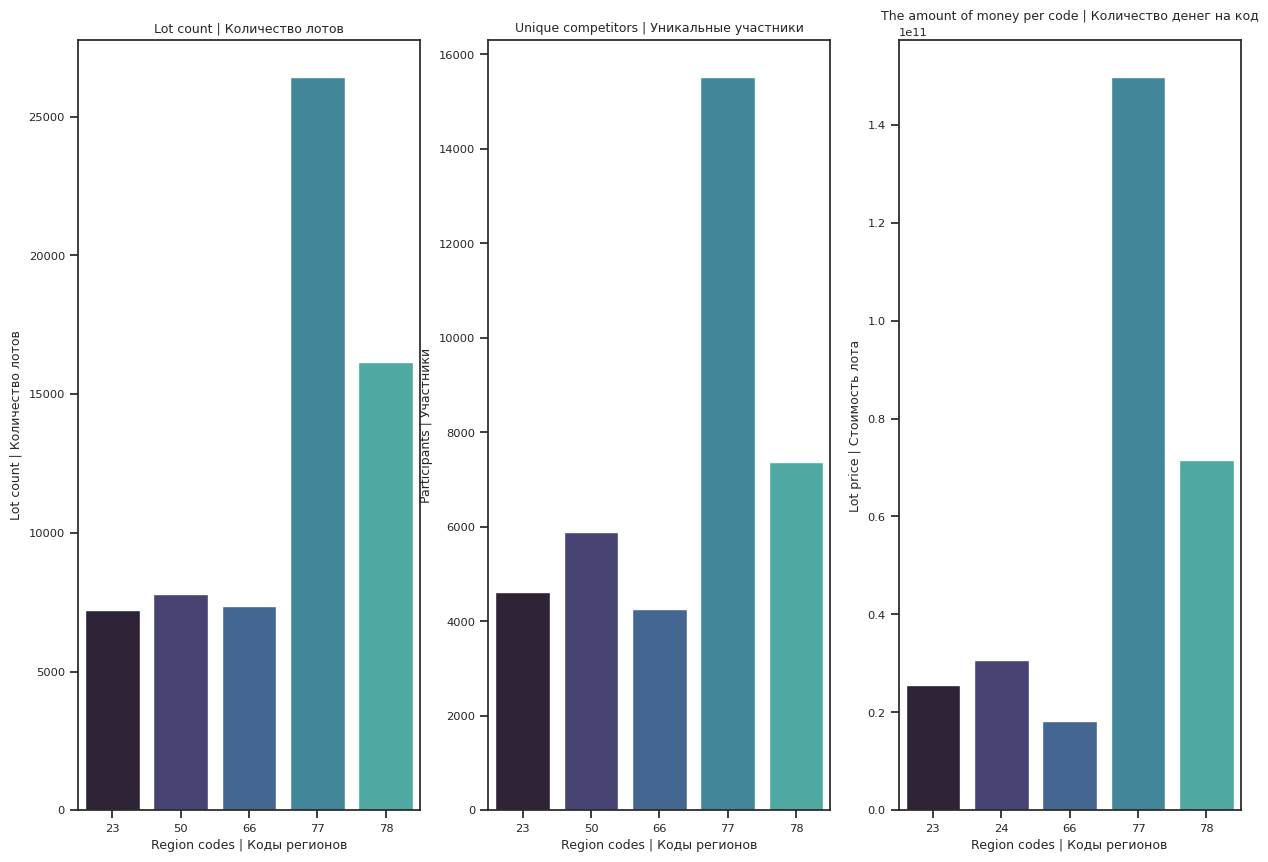

In [14]:
fig_regions, axs_regions = plt.subplots(1, 3)

# Lots count | Количество лотов:
lots_count_region_codes = df_lots["region_code"].value_counts().sort_values(ascending = False)

regions1 = sns.barplot(x = lots_count_region_codes[:5].index, y = lots_count_region_codes[:5], ax = axs_regions[0])
regions1.set(title = "Lot count | Количество лотов",
             xlabel = "Region codes | Коды регионов",
             ylabel = "Lot count | Количество лотов")

# Unique competitors | Уникальные участники:
unique_competitors_region_codes = df_merged.groupby("region_code")["participant_inn_kpp"].nunique().sort_values(ascending = False)

regions2 = sns.barplot(x = unique_competitors_region_codes[:5].index, y = unique_competitors_region_codes[:5], ax = axs_regions[1])
regions2.set(title = "Unique competitors | Уникальные участники",
             xlabel = "Region codes | Коды регионов",
             ylabel = "Participants | Участники")

# The amount of money per code | Количество денег на код:
lot_price_region_codes_sum = df_lots.groupby("region_code")["lot_price"].agg("sum").sort_values(ascending = False)

regions3 = sns.barplot(x = lot_price_region_codes_sum[:5].index, y = lot_price_region_codes_sum[:5], ax = axs_regions[2])
regions3.set(title = "The amount of money per code | Количество денег на код",
             xlabel = "Region codes | Коды регионов",
             ylabel = "Lot price | Стоимость лота")

fig_regions.show()

df_lots.groupby("region_code")["lot_price"].agg("median").sort_values(ascending = False)[:5]

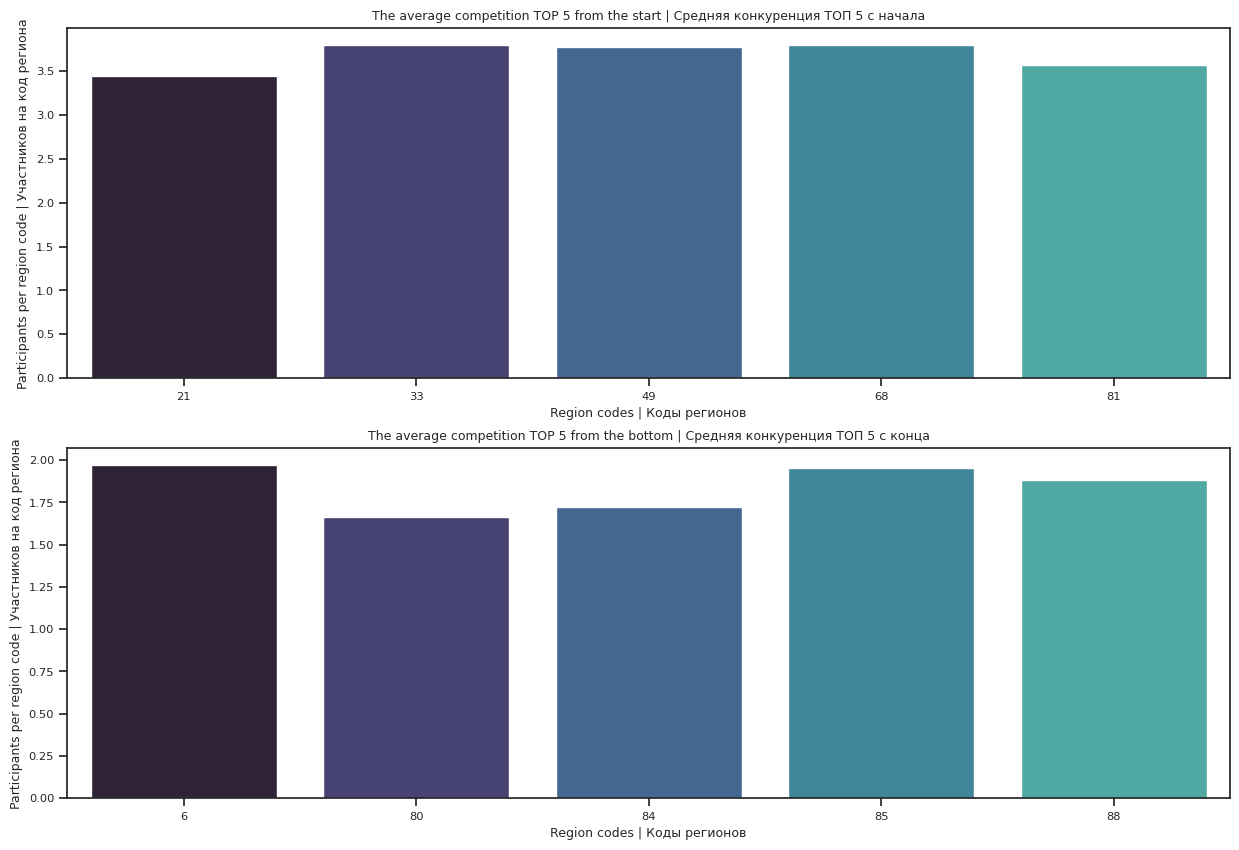

In [15]:
fig_regions_ac, axs_regions_ac = plt.subplots(2)

# The average competition TOP 5 from the start | Средняя конкуренция ТОП 5 с начала:
count_participants_region_codes = df_merged.groupby("region_code")["participant_inn_kpp"].count()
count_lots_region_code = df_lots.groupby("region_code")["pn_lot_md5"].count()
average_competition_region_codes = (count_participants_region_codes / count_lots_region_code).sort_values(ascending = False)[:5]

regions4 = sns.barplot(x = average_competition_region_codes.index, y = average_competition_region_codes, ax = axs_regions_ac[0])
regions4.set(title = "The average competition TOP 5 from the start | Средняя конкуренция ТОП 5 с начала",
             xlabel = "Region codes | Коды регионов",
             ylabel = "Participants per region code | Участников на код региона")

# The average competition TOP 5 from the bottom | Средняя конкуренция ТОП 5 с конца:
count_participants_region_codes = df_merged.groupby("region_code")["participant_inn_kpp"].count()
count_lots_region_code = df_lots.groupby("region_code")["pn_lot_md5"].count()
average_competition_region_codes = (count_participants_region_codes / count_lots_region_code).sort_values(ascending = True)[:5]

regions4 = sns.barplot(x = average_competition_region_codes.index, y = average_competition_region_codes, ax = axs_regions_ac[1])
regions4.set(title = "The average competition TOP 5 from the bottom | Средняя конкуренция ТОП 5 с конца",
             xlabel = "Region codes | Коды регионов",
             ylabel = "Participants per region code | Участников на код региона")

fig_regions_ac.show()

[Text(0.5, 1.0, 'The average competition TOP 5 from the bottom | Средняя конкуренция ТОП 5 с конца'),
 Text(0.5, 0, 'Region codes | Коды регионов'),
 Text(0, 0.5, 'Participants per region code | Участников на код региона')]

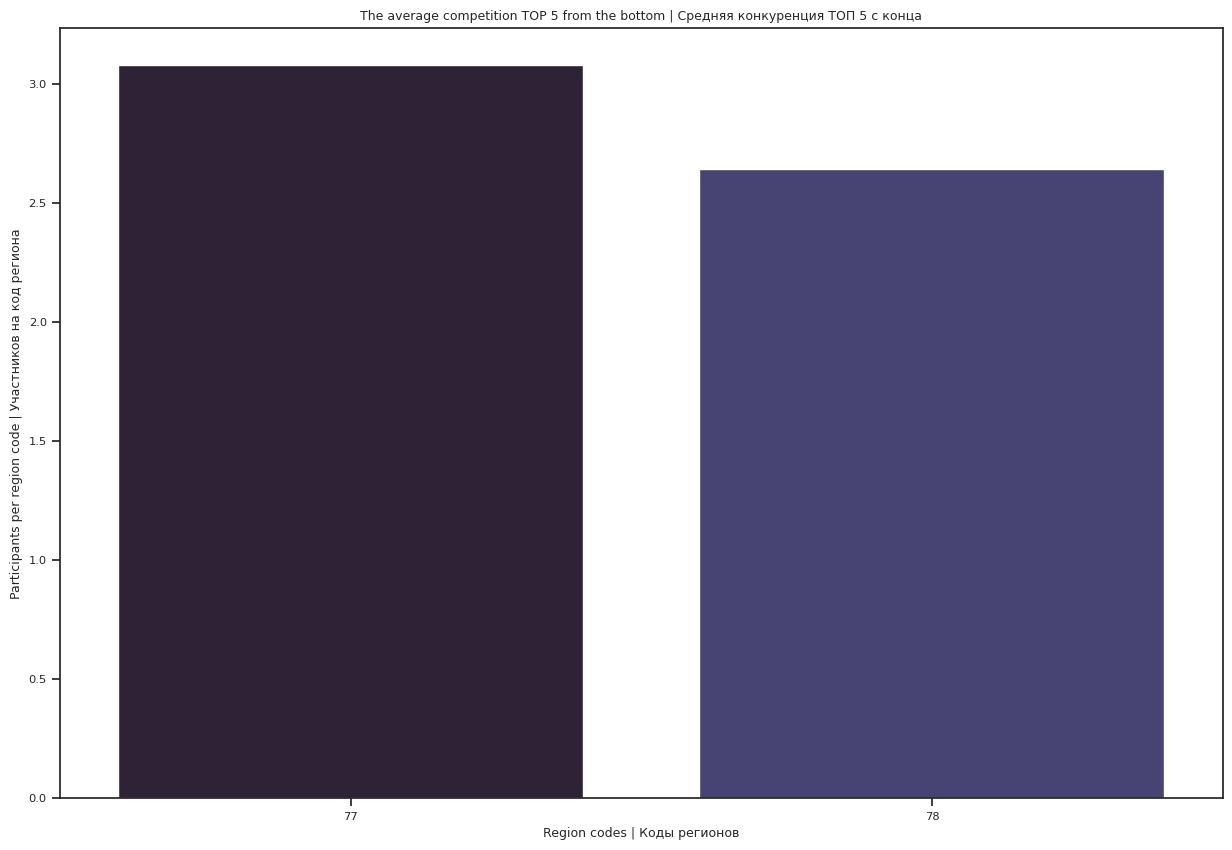

In [16]:
# The average competition for Moscow and Saint-Petersburg | Средняя конкуренция для Москвы и Санкт-Петербурга:
count_participants_region_codes = df_merged.groupby("region_code")["participant_inn_kpp"].count()
count_lots_region_code = df_lots.groupby("region_code")["pn_lot_md5"].count()
average_competition_region_codes = (count_participants_region_codes / count_lots_region_code)
average_competition_region_codes = average_competition_region_codes[(average_competition_region_codes.index == 77) |
                                                                    (average_competition_region_codes.index == 78)]

regions4 = sns.barplot(x = average_competition_region_codes.index, y = average_competition_region_codes)
regions4.set(title = "The average competition TOP 5 from the bottom | Средняя конкуренция ТОП 5 с конца",
             xlabel = "Region codes | Коды регионов",
             ylabel = "Participants per region code | Участников на код региона")

## Lot price | Цена закупки:

[Text(0.5, 1.0, 'The amount of money by years | Количество денег по годам'),
 Text(0.5, 0, 'Years | Года'),
 Text(0, 0.5, 'The amount of money | Количество денег')]

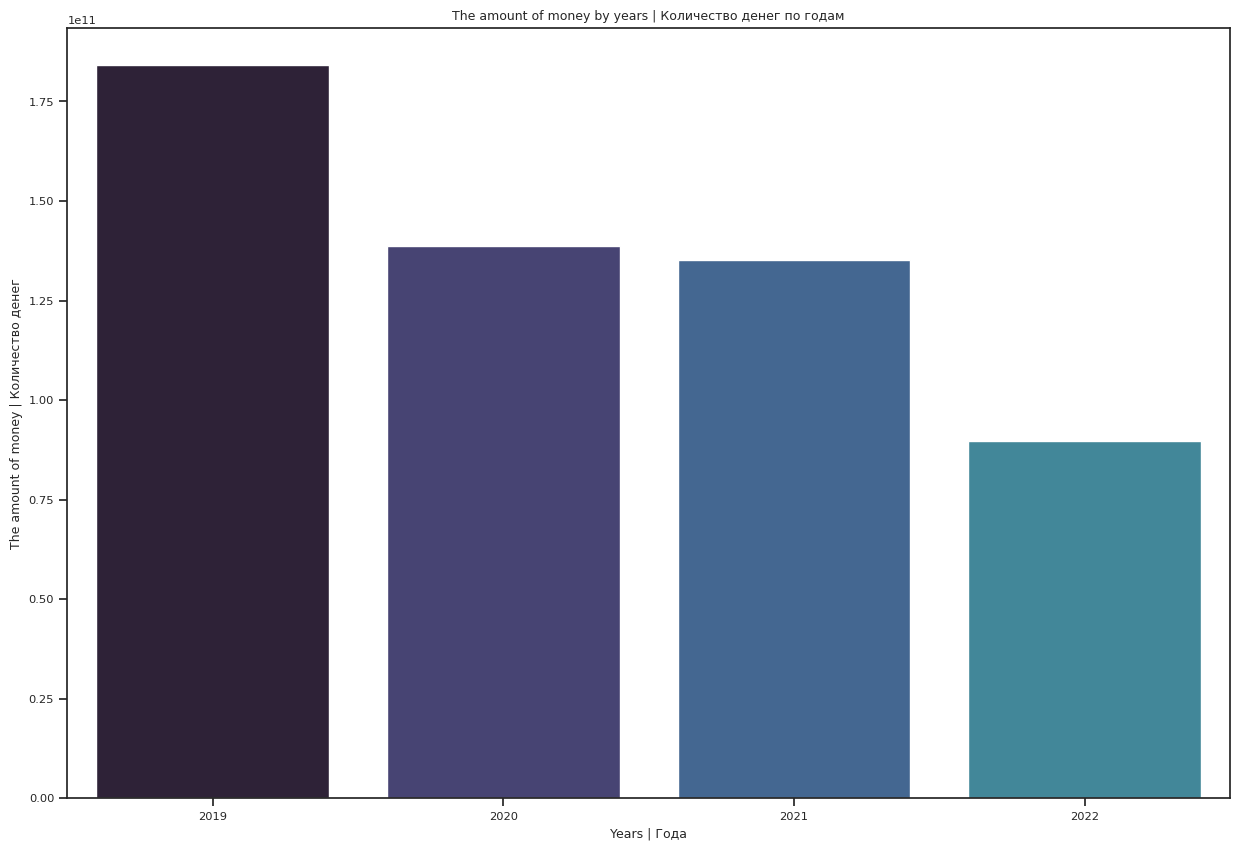

In [17]:
# The amount of money by years | Количество денег по годам:
lot_price_per_years = df_lots.groupby("year")["lot_price"].agg("sum")

lp1 = sns.barplot(x = lot_price_per_years.index, y = lot_price_per_years)
lp1.set(title = "The amount of money by years | Количество денег по годам",
        xlabel = "Years | Года",
        ylabel = "The amount of money | Количество денег")

In [18]:
trimmed_mean = trim_mean(a = df_lots["lot_price"], proportiontocut = .1)
i_q_r = iqr(df_lots["lot_price"])

print(f"Central tendency using trimmed mean | Мера центральной тенденции при использовании усечённого среднего = {round(trimmed_mean, 2)}")
print(f"Interquartile range | Интерквартильный размах = {round(i_q_r, 2)}")

Central tendency using trimmed mean | Мера центральной тенденции при использовании усечённого среднего = 425932.89
Interquartile range | Интерквартильный размах = 669622.98


## Lots | Закупки:

[Text(0.5, 1.0, 'Lots per year | Закупки по годам'),
 Text(0.5, 0, 'Years | Годы'),
 Text(0, 0.5, 'Lots | Закупки')]

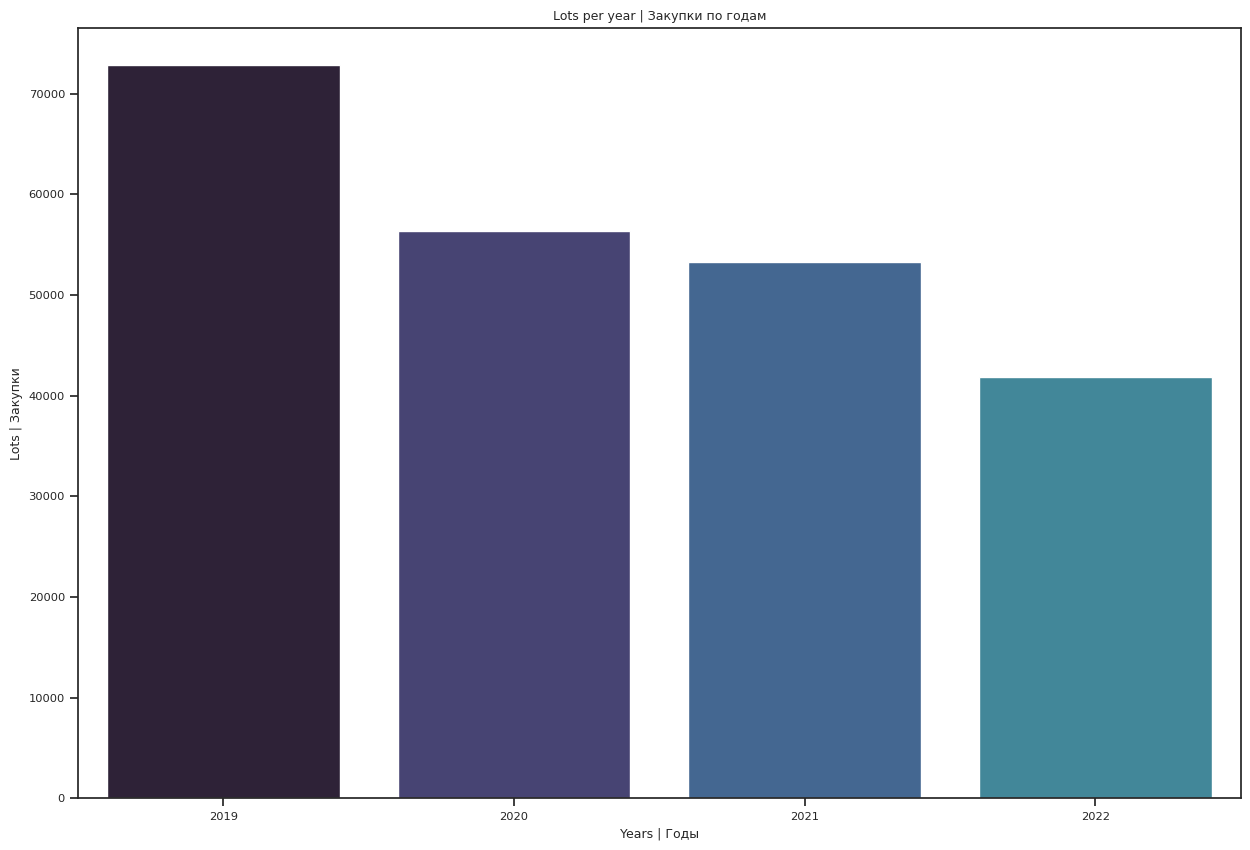

In [19]:
# Lots per years | Закупки по годам:
lots_per_years = df_lots.groupby("year")["pn_lot_md5"].count()

lots1 = sns.barplot(x = lots_per_years.index, y = lots_per_years)
lots1.set(title = "Lots per year | Закупки по годам",
          xlabel = "Years | Годы",
          ylabel = "Lots | Закупки")

## Participants | Поставщики:

[Text(0.5, 1.0, 'Unique amount of the participants | Уникальное количество поставщиков'),
 Text(0.5, 0, 'Years | Года'),
 Text(0, 0.5, 'Participants | Поставщики')]

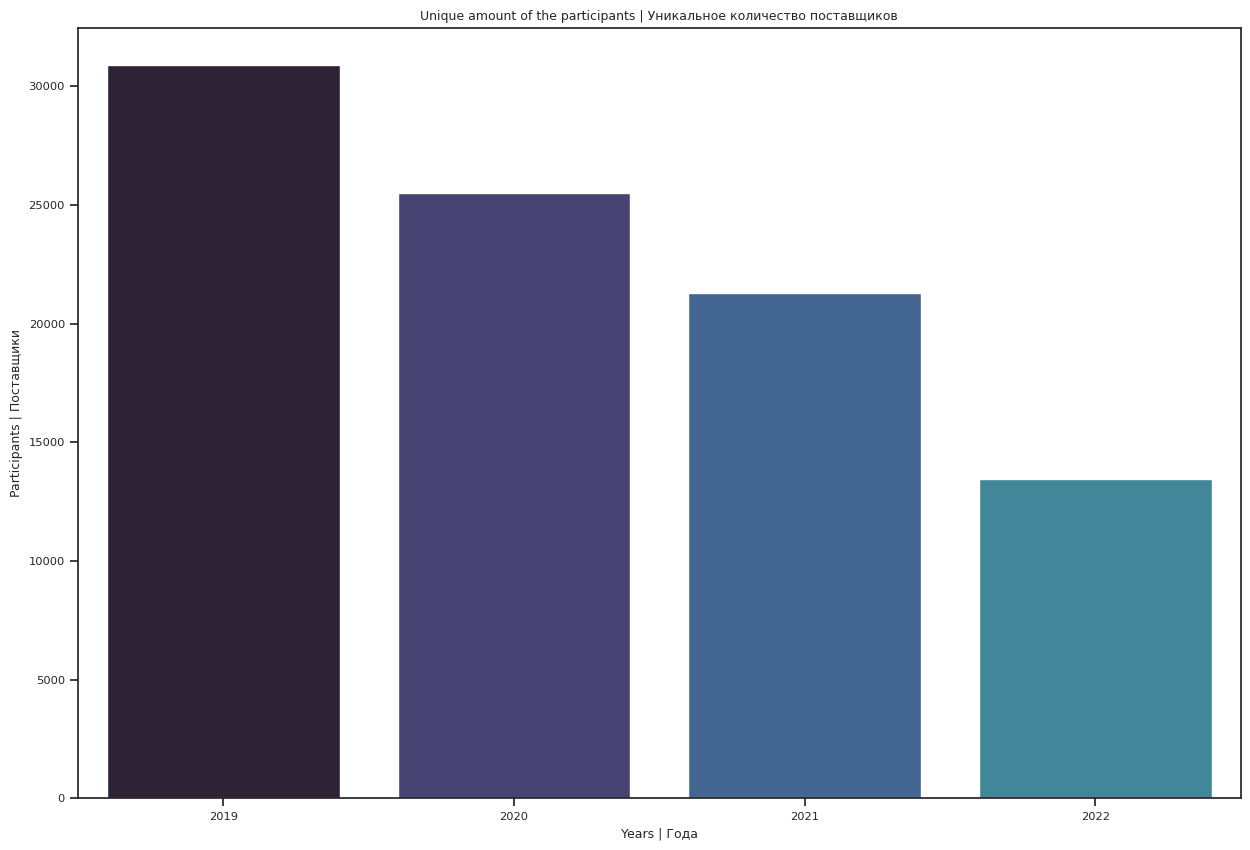

In [20]:
# Unique amount of the participants | Уникальное количество поставщиков:
participants_unique = df_merged.groupby("year")["participant_inn_kpp"].nunique()

participants2 = sns.barplot(x = participants_unique.index, y = participants_unique)
participants2.set(title = "Unique amount of the participants | Уникальное количество поставщиков",
                  xlabel = "Years | Года",
                  ylabel = "Participants | Поставщики")

## Cohort analysis | Когортный анализ:

In [21]:
df_merged["participation_month"] = df_merged["min_publish_date"].dt.to_period("M")
df_merged["cohort"] = df_merged.groupby("participant_inn_kpp")["min_publish_date"].transform("min").dt.to_period("M")

In [22]:
df_cohort = df_merged.groupby(["cohort", "participation_month"])\
            .agg(n_participants = ("participant_inn_kpp", "nunique"))\
            .reset_index(drop = False)

df_cohort["period_number"] = (df_cohort["participation_month"] - df_cohort["cohort"]).apply(attrgetter('n'))

In [23]:
cohort_pivot_table = df_cohort.pivot_table(index = "cohort", columns = "period_number", values = "n_participants")

In [24]:
cohort_size = cohort_pivot_table.iloc[:, 0]

retention_matrix = cohort_pivot_table.divide(cohort_size, axis = 0) * 100

<Axes: xlabel='period_number', ylabel='cohort'>

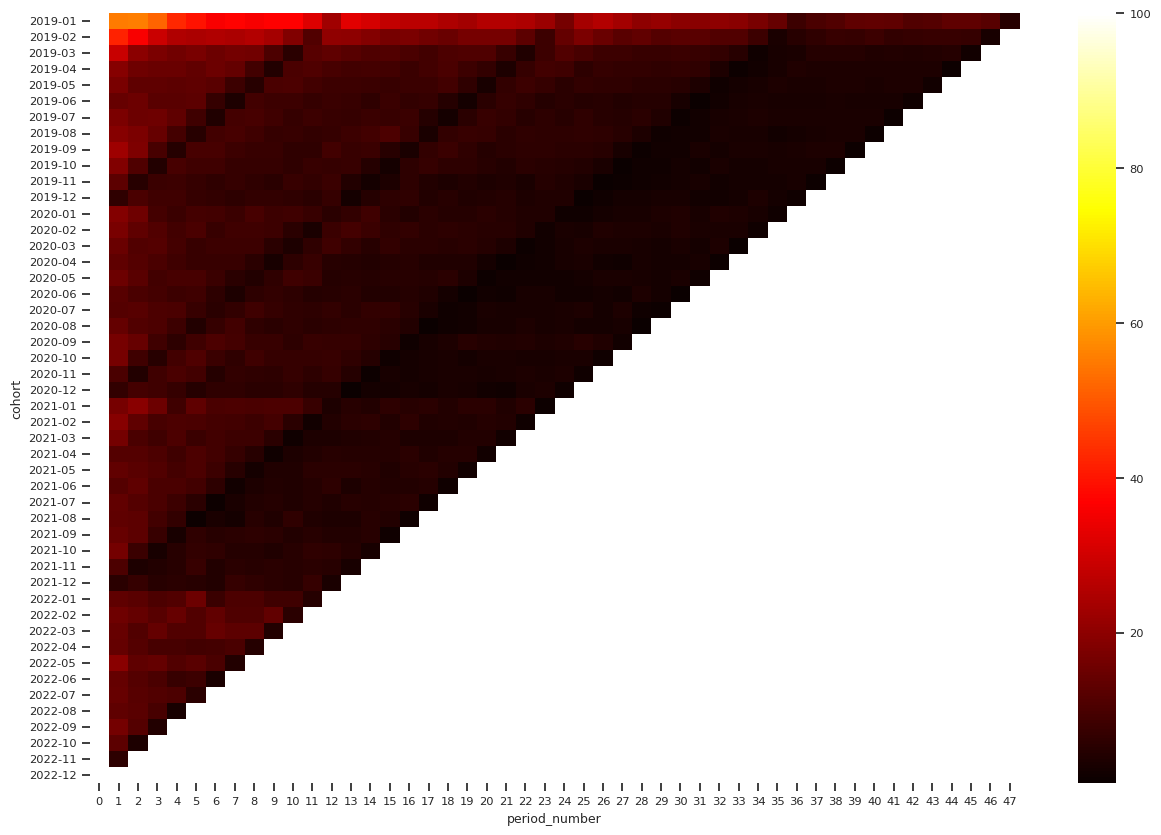

In [25]:
sns.heatmap(data = retention_matrix, cmap = "hot")

## Analyzing participant's behavior | Анализ поведения поставщиков:

### Participation frequency | Частота участий:

In [26]:
a = df_merged.groupby(["year", "customer_inn_kpp"])["pn_lot_md5"].count().reset_index()

In [27]:
a_2019 = a[(a["year"] == 2019) & (a["pn_lot_md5"] <= 10)]
a_2020 = a[(a["year"] == 2020) & (a["pn_lot_md5"] <= 10)]
a_2021 = a[(a["year"] == 2021) & (a["pn_lot_md5"] <= 10)]
a_2022 = a[(a["year"] == 2022) & (a["pn_lot_md5"] <= 10)]

In [28]:
a_2019_bins = pd.cut(a_2019["pn_lot_md5"], 5, precision = 0)
a_2020_bins = pd.cut(a_2020["pn_lot_md5"], 5, precision = 0)
a_2021_bins = pd.cut(a_2021["pn_lot_md5"], 5, precision = 0)
a_2022_bins = pd.cut(a_2022["pn_lot_md5"], 5, precision = 0)

In [29]:
print(a_2019_bins.value_counts(normalize = True),
      "\n\n",
      a_2020_bins.value_counts(normalize = True),
      "\n\n",
      a_2021_bins.value_counts(normalize = True),
      "\n\n",
      a_2022_bins.value_counts(normalize = True))

(1.0, 3.0]     0.413235
(3.0, 5.0]     0.233475
(5.0, 6.0]     0.155296
(6.0, 8.0]     0.112977
(8.0, 10.0]    0.085017
Name: pn_lot_md5, dtype: float64 

 (1.0, 3.0]     0.426353
(3.0, 5.0]     0.229220
(5.0, 6.0]     0.148660
(6.0, 8.0]     0.110002
(8.0, 10.0]    0.085765
Name: pn_lot_md5, dtype: float64 

 (1.0, 3.0]     0.434357
(3.0, 5.0]     0.233722
(5.0, 6.0]     0.155814
(6.0, 8.0]     0.099700
(8.0, 10.0]    0.076407
Name: pn_lot_md5, dtype: float64 

 (1.0, 3.0]     0.631414
(3.0, 5.0]     0.184785
(5.0, 6.0]     0.089397
(6.0, 8.0]     0.057125
(8.0, 10.0]    0.037279
Name: pn_lot_md5, dtype: float64


### The amount of participations > 1 time | Количество участий больше одного раза:

In [30]:
unique_participations = df_merged.groupby("participant_inn_kpp")["pn_lot_md5"].count()
participations_percentage = np.sum(unique_participations > 1) / df_merged["participant_inn_kpp"].nunique()

print(f"The amount of participations > 1 time / Количество участий больше одного раза = {round(participations_percentage * 100, 2)}%")

The amount of participations > 1 time / Количество участий больше одного раза = 55.97%


### Pairs of the participants and customers | Пары поставщиков и заказчиков:

In [31]:
df_merged_2019_1 = df_merged[(df_merged["year"] == 2019) & (df_merged["month"] <= 6)]
df_merged_2019_2 = df_merged[(df_merged["year"] == 2019) & (df_merged["month"] > 6)]

df_merged_2020_1 = df_merged[(df_merged["year"] == 2020) & (df_merged["month"] <= 6)]
df_merged_2020_2 = df_merged[(df_merged["year"] == 2020) & (df_merged["month"] > 6)]

df_merged_2021_1 = df_merged[(df_merged["year"] == 2021) & (df_merged["month"] <= 6)]
df_merged_2021_2 = df_merged[(df_merged["year"] == 2021) & (df_merged["month"] > 6)]

df_merged_2022_1 = df_merged[(df_merged["year"] == 2022) & (df_merged["month"] <= 6)]
df_merged_2022_2 = df_merged[(df_merged["year"] == 2022) & (df_merged["month"] > 6)]

In [32]:
joint_2019_1 = set(df_merged_2019_1["customer_inn_kpp"] + " " + df_merged_2019_1["participant_inn_kpp"])
joint_2019_2 = set(df_merged_2019_2["customer_inn_kpp"] + " " + df_merged_2019_2["participant_inn_kpp"])

joint_2020_1 = set(df_merged_2020_1["customer_inn_kpp"] + " " + df_merged_2020_1["participant_inn_kpp"])
joint_2020_2 = set(df_merged_2020_2["customer_inn_kpp"] + " " + df_merged_2020_2["participant_inn_kpp"])

joint_2021_1 = set(df_merged_2021_1["customer_inn_kpp"] + " " + df_merged_2021_1["participant_inn_kpp"])
joint_2021_2 = set(df_merged_2021_2["customer_inn_kpp"] + " " + df_merged_2021_2["participant_inn_kpp"])

joint_2022_1 = set(df_merged_2022_1["customer_inn_kpp"] + " " + df_merged_2022_1["participant_inn_kpp"])
joint_2022_2 = set(df_merged_2022_2["customer_inn_kpp"] + " " + df_merged_2022_2["participant_inn_kpp"])

In [33]:
print(round(len(joint_2019_1 & joint_2019_2) / len(joint_2019_1) * 100),\
      round(len(joint_2019_2 & joint_2020_1) / len(joint_2019_2) * 100),\
      round(len(joint_2020_1 & joint_2020_2) / len(joint_2020_1) * 100),\
      round(len(joint_2020_2 & joint_2021_1) / len(joint_2020_2) * 100),\
      round(len(joint_2021_1 & joint_2021_2) / len(joint_2021_1) * 100),\
      round(len(joint_2021_2 & joint_2022_1) / len(joint_2021_2) * 100),\
      round(len(joint_2022_1 & joint_2022_2) / len(joint_2022_1) * 100))

10 8 10 10 10 6 11
